In [1]:
# Module and data import
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data,
                                           import_real_data, import_real_energy_data)
from master_scripts.analysis_functions import (doubles_classification_stats, singles_classification_stats)
from master_scripts.plotting import plot_roc_curve
from sklearn.metrics import f1_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()

In [2]:
images = np.load(repo_root + "data/simulated/images_200k.npy")
images = images.reshape(images.shape[0], 16, 16, 1)
positions = np.load(repo_root + "data/simulated/positions_200k.npy")
energies = np.load(repo_root + "data/simulated/energies_200k.npy")
labels = np.load(repo_root + "data/simulated/labels_200k.npy")

In [3]:
# Set indices for train and validation
x_idx = np.arange(images.shape[0])
train_idx, val_idx = train_test_split(
    x_idx,
    random_state=120
)
s_idx_train, d_idx_train, c_idx_train = event_indices(positions[train_idx])
s_idx_val, d_idx_val, c_idx_val = event_indices(positions[val_idx])

In [2]:
# This one is essentially a denoiser
class ConvolutionalAutoEncoder(Model):
  def __init__(self):
    super(ConvolutionalAutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(16, 16, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
autoencoder = ConvolutionalAutoEncoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
history = autoencoder.fit(
    normalize_image_data(images[train_idx][s_idx_train]),
    normalize_image_data(images[train_idx][s_idx_train]),
    epochs=10,
    shuffle=True,
    validation_data=(normalize_image_data(images[val_idx]), normalize_image_data(images[val_idx]))
)

Epoch 1/10
2345/2345 [==============================] - 18s 8ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 2/10
2345/2345 [==============================] - 21s 9ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 3/10
2345/2345 [==============================] - 22s 9ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/10
2345/2345 [==============================] - 29s 12ms/step - loss: 4.0853e-04 - val_loss: 6.5280e-05
Epoch 5/10
2345/2345 [==============================] - 22s 9ms/step - loss: 2.5844e-05 - val_loss: 4.8359e-05
Epoch 6/10
2345/2345 [==============================] - 30s 13ms/step - loss: 1.6441e-05 - val_loss: 3.2176e-05
Epoch 7/10
2345/2345 [==============================] - 28s 12ms/step - loss: 1.2009e-05 - val_loss: 3.1833e-05
Epoch 8/10
2345/2345 [==============================] - 27s 11ms/step - loss: 9.3869e-06 - val_loss: 2.4035e-05
Epoch 9/10
2345/2345 [==============================] - 30s 13ms/step - loss: 7.8394e-06 - val_loss: 2.3367e-05
Epoch 10/10
2345/234

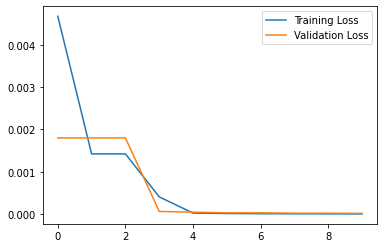

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [9]:
s_encoded_imgs = autoencoder.encoder(normalize_image_data(images[val_idx][s_idx_val])).numpy()
s_decoded_imgs = autoencoder.decoder(s_encoded_imgs).numpy()
d_encoded_imgs = autoencoder.encoder(normalize_image_data(images[val_idx][d_idx_val])).numpy()
d_decoded_imgs = autoencoder.decoder(d_encoded_imgs).numpy()

s_mse = np.mean(np.square(normalize_image_data(images[val_idx][s_idx_val]) - s_decoded_imgs), axis=(1,2))
d_mse = np.mean(np.square(normalize_image_data(images[val_idx][d_idx_val]) - d_decoded_imgs), axis=(1,2))

/home/geir/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/geir/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


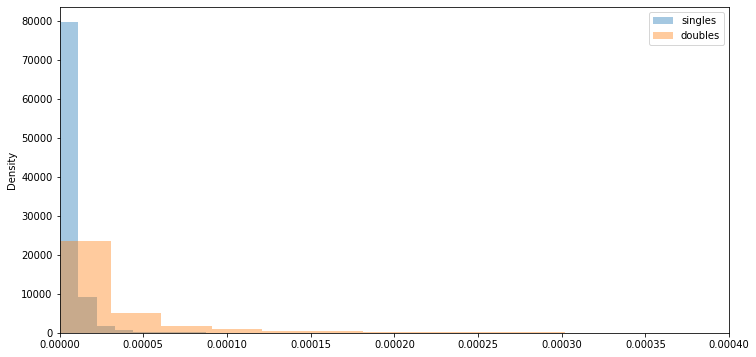

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(s_mse, label="singles", ax=ax)
sns.distplot(d_mse, label="doubles", ax=ax)
ax.set_xlim([0.0, 0.0004])
ax.legend()
plt.show()

In [ ]:
n = 10
plt.figure(figsize=(30, 6))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(images[val_idx][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Try AE on real events

In [3]:
events, images = import_real_energy_data(repo_root + "data/real/decaydata_100k.txt")

In [4]:
# Set indices for train and validation
x_idx = np.arange(images.shape[0])
train_idx, val_idx = train_test_split(
    x_idx,
    random_state=120
)

In [5]:
autoencoder = ConvolutionalAutoEncoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
history = autoencoder.fit(
    normalize_image_data(images[train_idx]),
    normalize_image_data(images[train_idx]),
    epochs=10,
    shuffle=True,
    validation_data=(normalize_image_data(images[val_idx]), normalize_image_data(images[val_idx]))
)

Epoch 1/10
2344/2344 [==============================] - 14s 6ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 2/10
2344/2344 [==============================] - 13s 6ms/step - loss: 7.0459e-04 - val_loss: 7.7004e-05
Epoch 3/10
2344/2344 [==============================] - 13s 6ms/step - loss: 6.2487e-05 - val_loss: 6.3598e-05
Epoch 4/10
2344/2344 [==============================] - 13s 6ms/step - loss: 5.1304e-05 - val_loss: 5.2846e-05
Epoch 5/10
2344/2344 [==============================] - 13s 6ms/step - loss: 4.6330e-05 - val_loss: 4.8341e-05
Epoch 6/10
2344/2344 [==============================] - 13s 6ms/step - loss: 4.3173e-05 - val_loss: 4.3674e-05
Epoch 7/10
2344/2344 [==============================] - 13s 6ms/step - loss: 4.0882e-05 - val_loss: 4.7278e-05
Epoch 8/10
2344/2344 [==============================] - 14s 6ms/step - loss: 3.9351e-05 - val_loss: 4.0692e-05
Epoch 9/10
2344/2344 [==============================] - 14s 6ms/step - loss: 3.7990e-05 - val_loss: 3.9380e-05
Epoch 10/

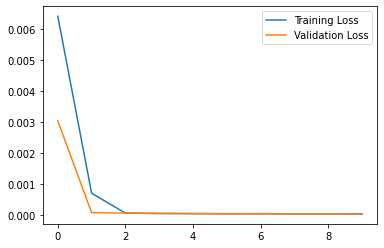

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

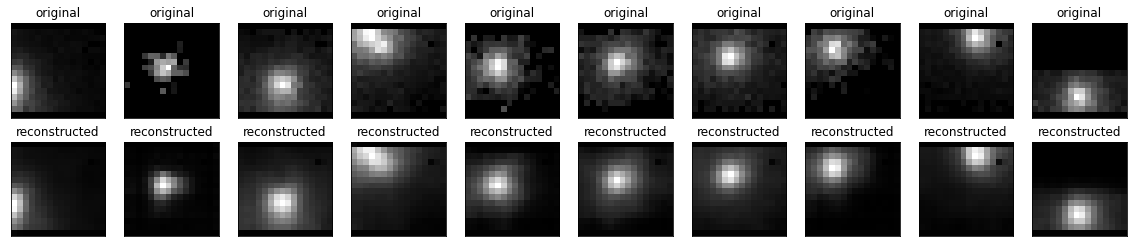

In [13]:
encoded_imgs = autoencoder.encoder(normalize_image_data(images[val_idx])).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images[val_idx][i].reshape(16,16))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(16,16))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## What happens if we run a simulated image through the autoencoder?

In [15]:
sim_images = np.load(repo_root + "data/simulated/images_200k.npy")
sim_images = sim_images.reshape(sim_images.shape[0], 16, 16, 1)
sim_positions = np.load(repo_root + "data/simulated/positions_200k.npy")
sim_energies = np.load(repo_root + "data/simulated/energies_200k.npy")
sim_labels = np.load(repo_root + "data/simulated/labels_200k.npy")

In [16]:
# Set indices for train and validation
sim_x_idx = np.arange(sim_images.shape[0])
sim_train_idx, sim_val_idx = train_test_split(
    sim_x_idx,
    random_state=120
)

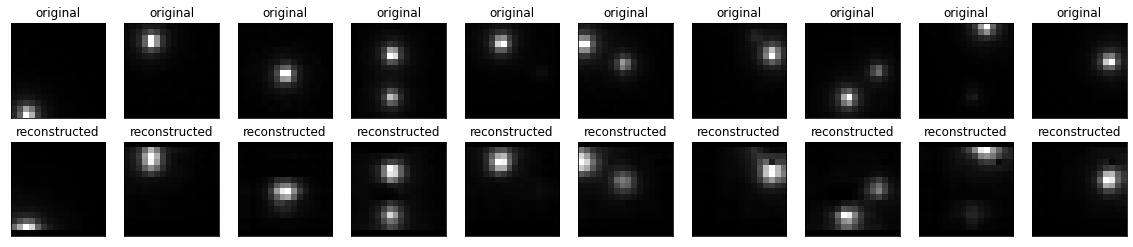

In [18]:
sim_encoded_imgs = autoencoder.encoder(normalize_image_data(sim_images[sim_val_idx])).numpy()
sim_decoded_imgs = autoencoder.decoder(sim_encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(sim_images[sim_val_idx][i].reshape(16,16))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(sim_decoded_imgs[i].reshape(16,16))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()